In [102]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np_  # Original numpy
import pennylane as qml
import scipy as sp

import torch

# Pennylane numpy
from pennylane import numpy as np 

In [103]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
hamiltonian = qml.Hamiltonian(coeffs = [-0.5], observables = [qml.PauliZ(0)])

In [104]:
# Global Parameters
Tau_global = 5e-2   # Dephase tau
Paras_global = np.zeros(2)
Phi_global = 0
Gamma_ps = 0

def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    
    return 1 - np.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau}
$$

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

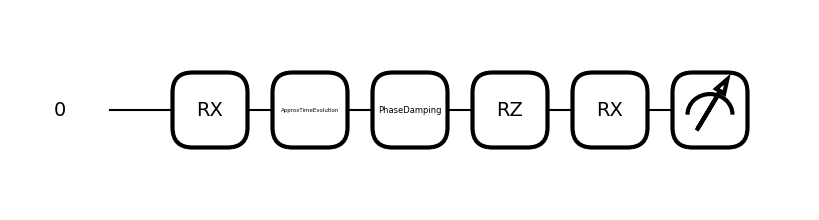

In [105]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

@qml.qnode(dev, interface='torch', diff_method='backprop')
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([
        [np.sqrt(1 - Gamma_ps), 0],
        [0, 1]
    ])
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = 0)
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [121]:
paras = torch.tensor([np.pi/2, np.pi/2])

density_matrix = (circuit(paras))

type(density_matrix)

torch.Tensor

In [122]:
Gamma_ps = 0.8
K = np.array([
    [np.sqrt(1 - Gamma_ps), 0],
    [0, 1]
])

K

tensor([[0.4472136, 0.       ],
        [0.       , 1.       ]], requires_grad=True)

In [124]:
K = torch.tensor(K)

K

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_81656/2676095398.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  K = torch.tensor(K)


tensor([[0.4472, 0.0000],
        [0.0000, 1.0000]], dtype=torch.float64)

In [108]:
density_matrix

tensor([[0.5000+2.7756e-17j, 0.4756-4.8850e-15j],
        [0.4756+4.8850e-15j, 0.5000+2.7756e-17j]], dtype=torch.complex128)

In [107]:
K @ density_matrix @ K


RuntimeError: expected scalar type Double but found ComplexDouble

In [ ]:

# Gamma_ps = torch.tensor(0.8)
Gamma_ps = 0.8

K = np.array([
    [np.sqrt(1 - Gamma_ps), 0],
    [0, 1]
])

K = torch.tensor(K)
type(K)

torch.Tensor

In [ ]:
phi_temp = torch.tensor(np.pi/2)
paras = torch.tensor([np.pi/2, np.pi/2])
Paras_global = paras

Post_selection_Dephase(phi_temp)

TypeError: unsupported operand type(s) for @: 'tensor' and 'Tensor'

In [ ]:
# Step1: clarify circuit_1 

paras = torch.tensor([np.pi/2, np.pi/2])
Paras_global = paras

type(circuit(paras))

torch.Tensor

In [ ]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global = paras
    phi = np.array([Phi_global])

    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [ ]:
cselect = None
def cost(paras):
    return torch.real(Cost_function(paras, cselect))

In [ ]:
Paras_init = np.zeros(2)
Paras_init[:2] = np.pi/2

# torch.real(Cost_function(Paras_init))

cost(Paras_init)

TypeError: Cost_function() takes 1 positional argument but 2 were given

In [ ]:
class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3

# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        sweep_data (tuple): (start, end, step) values for the sweep.
        initial_parameters (numpy_array): Array of parameters for the qnode.
        gamma_ps (int): The Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array containing phi, CFI, and optimized parameters.
    """
    
    # Create Data array
    PHI = np_.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np_.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Determine initial parameters based on the iteration
            if iteration == 1:
                Paras_Temporary = initial_parameters
            else:
                Paras_Temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            # Update the global Phi value
            Phi_global = phi_current
            
            # Determine constraints
            N = int(phi_current / np.pi) + 1            
            Constraints = get_constraints(N, phi_current)
                
            # Optimize the data
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                Cost_function, 
                Paras_Temporary, 
                method = 'L-BFGS-B', 
                bounds = Constraints,
                
                tol=1e-12,
                options={
                    'ftol': 1e-12, 
                    'gtol': 1e-12
                }
            )
            
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Result_BFGS.x
            
    return Data

def get_constraints(N, phi_current):
    if ((phi_current < 1.4 * N) or (phi_current > 1.7 * N)):
        return [(0, np.pi)] * 2
    else:
        # Constraints = [(-float('inf'), float('inf'))] * 2 
        return [(-np.pi/2, (3*np.pi)/2)] * 2 

In [ ]:
# tau_plot = 0, 5e-2, 2e-1, 5e-1, 1, 2, 3, 4

# Sweep_data = np_.array([0, np.pi*4,  1e-2])  #1e-2 ~ (4pi + 1e-2)
# Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

# Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

# for idx, tau_current in enumerate(tau_plot):
#     Tau_global = tau_current
    
#     Paras_init = np.zeros(2)
#     Paras_init[:2] = np.pi/2

#     Gamma_ps_preset = 1e-10
#     Set_Iterations = 1

#     Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)

#     Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:,DataIndex.THETA_X.value]
#     Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:,DataIndex.PHI_Z.value]

#     plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label = f'$\\tau$ = {tau_current}')

# plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
# plt.xlabel('Time')
# plt.ylabel('CFI')
# plt.grid()
# plt.legend()

In [ ]:
for idx, tau in enumerate(tau_plot):
    # if idx, tau != 4:
        plt.plot(Sweep_data_arange, Para_store[idx][:, 1], label = f'$\\tau$ = {tau}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
# plt.yticks([-np.pi, 0, np.pi, 2*np.pi], ['$-\pi$', '0', '$\pi$', '$2\pi$'])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(0, np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

NameError: name 'tau_plot' is not defined

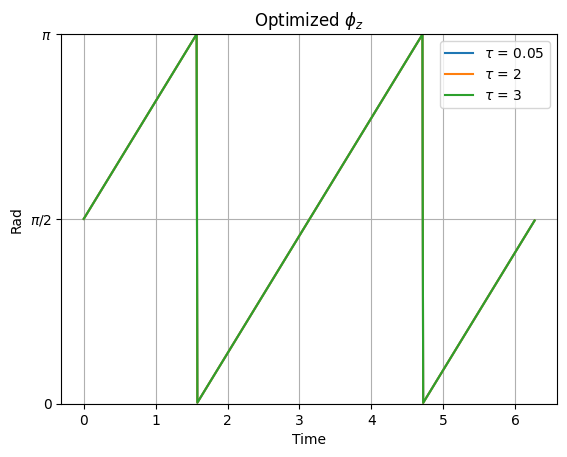

In [ ]:
slice = int(len(Sweep_data_arange) / 2)

tau_order = 1, 5, 6

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(0, 1*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

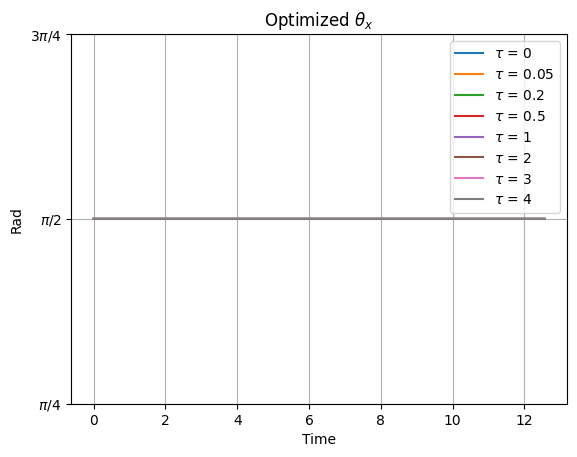

In [ ]:
for idx, tau in enumerate(tau_plot):
    plt.plot(Sweep_data_arange, Para_store[idx][:, 0], label = f'$\\tau$ = {tau}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()